# Demo 3 - Remote parallel inversion [distributed]

Demo for site visit | Brendan Smithyman | April 8, 2015

In [1]:
# profile = 'phobos'   # remote workstation
# profile = 'pantheon' # remote cluster
# profile = 'zeus' # remote workstation
profile = 'mpi' # local machine

In [2]:
import numpy as np
from zephyr.Dispatcher import SeisFDFDDispatcher
from zephyr.Parallel import CommonReducer
from IPython.parallel import Reference

In [3]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib
%matplotlib inline

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('png')
matplotlib.rcParams['savefig.dpi'] = 150 # Change this to adjust figure size

# Plotting options
font = {
    'family': 'Bitstream Vera Sans',
    'weight': 'normal',
    'size': 8,
}

matplotlib.rc('font', **font)

In [4]:
lclip = 2000
hclip = 3000
clipscale = 0.1
sms = 0.5
rms = 0.5

def plotField(u):
    clip = clipscale*abs(u).max()
    plt.imshow(u.real, cmap=cm.bwr, vmin=-clip, vmax=clip)

def plotModel(v):
    plt.imshow(v.real, cmap=cm.jet, vmin=lclip, vmax=hclip)

def plotGeometry(geom):
    
    srcpos = geom['src'][:,::2]
    recpos = geom['rec'][:,::2]
    
    axistemp = plt.axis()
    plt.plot(srcpos[:,0], srcpos[:,1], 'kx', markersize=sms)
    plt.plot(recpos[:,0], recpos[:,1], 'kv', markersize=rms)
    plt.axis(axistemp)

In [5]:
cellSize    = 1             # m
nx          = 164           # count
nz          = 264           # count
freqs       = [1e2, 2e2, 3e2, 4e2] # Hz
freeSurf    = [False, False, False, False] # t r b l
nPML        = 32            # number of PML points
nky         = 1             # number of y-directional plane-wave components

In [6]:
velocity    = 2500          # m/s
vanom       = 100           # m/s
density     = 2700          # units of density
Q           = 500           # can be inf

In [7]:
srcs        = np.array([np.ones(101)*32, np.zeros(101), np.linspace(32, 232, 101)]).T
recs        = np.array([np.ones(101)*132, np.zeros(101), np.linspace(32, 232, 101)]).T
nsrc        = len(srcs)
nrec        = len(recs)
recmode     = 'fixed'

geom        = {
    'src':  srcs,
    'rec':  recs,
    'mode': 'fixed',
}

In [8]:
cache       = False         # whether to cache computed wavefields for a given source
cacheDir    = '.'

parFac = 1
chunksPerWorker = 0.5       # NB: parFac * chunksPerWorker = number of source array subsets
ensembleClear = False

In [9]:
dims        = (nx,nz)       # tuple
rho         = np.fliplr(np.ones(dims) * density)
nfreq       = len(freqs)    # number of frequencies
nsp         = nfreq * nky   # total number of 2D subproblems
cPert       = np.zeros(dims)
cPert[(nx/2)-20:(nx/2)+20,(nz/2)-20:(nz/2)+20] = vanom
c           = np.fliplr(np.ones(dims) * velocity)
cFlat       = c.copy()
c          += np.fliplr(cPert)
cTrue       = c

In [10]:
# Base configuration for all subproblems
systemConfig = {
    'dx':   cellSize,       # m
    'dz':   cellSize,       # m
    'c':        c.T,        # m/s
    'rho':      rho.T,      # density
    'Q':        Q,          # can be inf
    'nx':       nx,         # count
    'nz':       nz,         # count
    'freeSurf': freeSurf,   # t r b l
    'nPML':     nPML,
    'geom':     geom,
    'cache':    cache,
    'cacheDir': cacheDir,
    'freqs':    freqs,
    'nky':      nky,
    'parFac':   parFac,
    'chunksPerWorker':  chunksPerWorker,
    'profile':  profile,
    'ensembleClear':    ensembleClear,
#     'MPI': False,
#    'Solver':   Reference('SimPEG.SolverWrapD(scipy.sparse.linalg.splu)'),#Solver,
}

In [11]:
%%time
sp = SeisFDFDDispatcher(systemConfig)
sp.remote.dview.activate()
sp.remote.e0.activate('e0')
survey, problem = sp.spawnInterfaces()
sxs = survey.genSrc()
sp.srcs = sxs

CPU times: user 244 ms, sys: 34 ms, total: 278 ms
Wall time: 878 ms


In [12]:
%%time
sp.forward()
dObs = sp.dPred
sp.dObs = dObs

CPU times: user 3.05 s, sys: 639 ms, total: 3.69 s
Wall time: 29.5 s


In [13]:
%%time
sp.rebuildSystem(cFlat.T)
sp.forward()

CPU times: user 76 ms, sys: 9.86 ms, total: 85.8 ms
Wall time: 141 ms


In [14]:
dPred = sp.dPred

In [15]:
dResid = sp.residual
misfit = sp.misfit

In [16]:
%%time
sp.backprop()
g = sp.g

CPU times: user 3.02 s, sys: 656 ms, total: 3.67 s
Wall time: 28.3 s


In [17]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


<matplotlib.colorbar.Colorbar instance at 0x1138cde60>

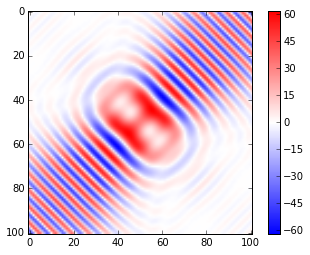

In [18]:
ind = dResid[1].real
clip = abs(ind).max()
imshow(ind, vmin=-clip, vmax=clip, cmap=cm.bwr)
colorbar()

<matplotlib.colorbar.Colorbar instance at 0x113f9a368>

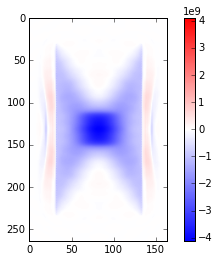

In [19]:
ind = (g[0]+g[1]+g[2]+g[3]).real
clip = abs(ind).max()
imshow(ind, vmin=-clip, vmax=clip, cmap=cm.bwr)
colorbar()

In [20]:
uF = sp.uF
uB = sp.uB

<matplotlib.colorbar.Colorbar instance at 0x1315a6878>

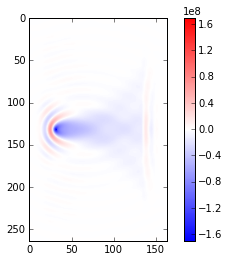

In [21]:
ind = (uF[0][50] * uB[0][50]).real
clip = abs(ind).max()
imshow(ind, vmin=-clip, vmax=clip, cmap=cm.bwr)
colorbar()